In [1]:
from __future__ import annotations

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
import os

os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ['MUJOCO_GL'] = 'egl'

class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=11,
        agent_start_pos=(5, 5),
        agent_start_dir=3,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        # if max_steps is None:
        #     max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        for i in range(1, 10):
            if i != 3:
                self.grid.set(i, 4, Wall())
            if i != 7:
                self.grid.set(i, 6, Wall())
    
        # Generate vertical separation wall
        for i in range(0, height):
            if i in set({1,5,9}):
                continue
            if i in set({2,3}):
                self.grid.set(4, i, Wall())
            else:
                self.grid.set(6, i, Wall())
        
        # Place the door and key
        # self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        # self.grid.set(3, 6, Key(COLOR_NAMES[0]))

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 3, height - 3)
        self.put_obj(Goal(), 2, 2)
        self.put_obj(Goal(), width - 2, 5)
        self.put_obj(Goal(), 1, 5)
        self.put_obj(Goal(), 3, height - 2)
        self.put_obj(Goal(), width - 4, 1)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

env = SimpleEnv(size=11, agent_start_pos=(5, 5), agent_start_dir=3, render_mode='rgb_array', max_steps=100)

In [2]:
trajs = {
    'observations': [
        [(5, 5, 3), (5, 5, 0), (6, 5, 0), (7, 5, 0), (8, 5, 0), (9, 5, 0), (9, 5, 0)],
        [(5, 5, 3), (5, 5, 2), (4, 5, 2), (3, 5, 2), (2, 5, 2), (1, 5, 2), (1, 5, 2)],
        [(3, 5, 2), (3, 5, 3), (3, 4, 3), (3, 3, 3), (3, 2, 3), (3, 2, 2), (2, 2, 2)],
        [(7, 5, 0), (7, 5, 1), (7, 6, 1), (7, 7, 1), (7, 8, 1), (7, 8, 0), (8, 8, 0)],
        [(3, 2, 3), (3, 1, 3), (3, 1, 0), (4, 1, 0), (5, 1, 0), (6, 1, 0), (7, 1, 0)],
        [(7, 8, 1), (7, 9, 1), (7, 9, 2), (6, 9, 2), (5, 9, 2), (4, 9, 2), (3, 9, 2)]
    ],
    'actions': [
        [1, 2, 2, 2, 2, 3],
        [0, 2, 2, 2, 2, 3],
        [1, 2, 2, 2, 0, 2],
        [1, 2, 2, 2, 0, 2],
        [2, 1, 2, 2, 2, 2],
        [2, 1, 2, 2, 2, 2],
    ],
}

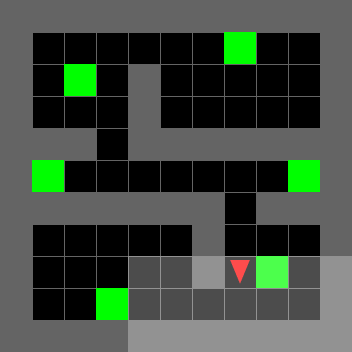

In [3]:
from PIL import Image
env.reset()
traj_idx = 5
env.agent_pos = trajs['observations'][traj_idx][0][:2]
env.agent_dir = trajs['observations'][traj_idx][0][2]
actions = trajs['actions'][traj_idx]
rgb_array = env.render()
img = Image.fromarray(rgb_array)
display(img)

(352, 352, 3)


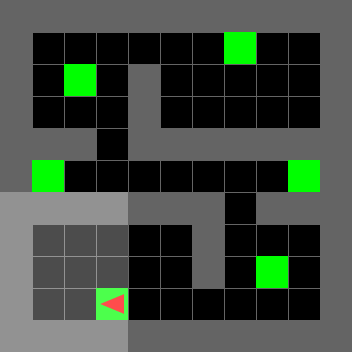

In [4]:
x, y = env.agent_pos
d = env.agent_dir
agent_obs = [(x,y,d)]
rewards = []
for a in actions:
    obs, reward, terminated, truncated, _ = env.step(a)
    x, y = env.agent_pos
    d = env.agent_dir
    agent_obs.append((x,y,d))
    if terminated:
        rewards.append(1)
        break
    rewards.append(0)
rgb_array = env.render()
img = Image.fromarray(rgb_array)
print(rgb_array.shape)
display(img)

In [5]:
# traj = {
#     'observations': agent_obs,
#     'actions': actions,
#     'rewards': rewards,
# }
# traj


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
from tqdm import tqdm
import cv2
import shutil


def eval(env, policy, test_starting_pos, test_goal_pos, save_dir):
    policy.eval()
    success = []

    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok=True)

    for i, (start, goal) in enumerate(zip(test_starting_pos, test_goal_pos)):
        env.reset()
        env.agent_pos = start[:2]
        env.agent_dir = start[2]
        reward = 0.
        imgs = [env.render()]
        
        terminated = False
    
        while not terminated:
            x, y = env.agent_pos
            d = env.agent_dir
            agent_obs = torch.tensor([[x, y, d]]).to('cuda')
            a = policy(agent_obs, torch.tensor(goal, device='cuda')[None]).argmax(dim=-1)
            _, _, terminated, truncated, _ = env.step(a.cpu().numpy())
            imgs.append(env.render())
            if terminated or truncated:
                reward = float(np.linalg.norm(np.array(env.agent_pos) - np.array(goal)) == 0)
                break
        
        success.append(reward)
        video_writer = cv2.VideoWriter(f'{save_dir}/start:{start}_goal:{goal}.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 1.0, (352, 352))
        for img in imgs:
            video_writer.write(img)
        video_writer.release()
    
    success = torch.tensor(success)
    policy.train()
    
    return success


test_starting_pos = [[5,5,3], [5,5,3], [5,5,3], [5,5,3]]
test_goal_pos = [[2, 2], [8, 8], [3, 9], [7,1]]

In [7]:

class MiniGridDataset(Dataset):
    def __init__(self, trajs):
        super().__init__()
        self.observations = trajs['observations']
        self.actions = trajs['actions']
        # self.rewards = trajs['rewards']
        # self.terminal = trajs['terminal']

    def __len__(self):
        return len(self.actions) * len(self.actions[0])

    def __getitem__(self, index):
        i = index // len(self.actions[0])
        j = index - i * len(self.actions[0])
        print(i, j)
        obs = torch.tensor(self.observations[i][j])
        action = torch.tensor([self.actions[i][j]])
        next_obs = torch.tensor(self.observations[i][j+1])
        goal = torch.tensor(random.choice(self.observations[i][j + 1:])[:2])
        reward = torch.tensor(all(obs[:2] == goal[:2]), dtype=torch.float32)
        one_hot_action = torch.eye(4)[action].view(-1)
        # goal = torch.tensor(self.observations[i][-1][:2])
        mask = 1 - reward
        
        return obs, action, reward, next_obs, goal, mask, one_hot_action

In [8]:
import torch.nn as nn
import torch

class GoalCondObsEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # self.obs_enc = nn.Linear(input_dim, hidden_dim)
        self.x_emb = nn.Embedding(10, 16)
        self.y_emb = nn.Embedding(10, 16)
        self.d_emb = nn.Embedding(4, 8)
    
    def forward(self, states, goals):
        state_x = self.x_emb(states[:, 0])
        state_y = self.y_emb(states[:, 1])
        state_d = self.d_emb(states[:, 2])
        goal_x = self.x_emb(goals[:, 0])
        goal_y = self.y_emb(goals[:, 1])
        # state_goal = torch.cat([states, goals], dim=-1).float()
        # obs_emb = self.obs_enc(state_goal)
        obs_emb = torch.cat([state_x, state_y, state_d, goal_x, goal_y], dim=-1).float()
        

        return obs_emb

class BCPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim) -> None:
        super().__init__()
        self.obs_enc = GoalCondObsEncoder(input_dim, hidden_dim)
        
        self.policy_network = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 4)
        )

    
    def forward(self, states, goals):
        obs_emb = self.obs_enc(states, goals)
        actions = self.policy_network(obs_emb)

        return actions

In [9]:
traj_dataset = MiniGridDataset(trajs)
traj_dataloader = DataLoader(traj_dataset, batch_size=8, shuffle=True)
bc_policy = BCPolicy(5, 72)
bc_policy.to('cuda:0')
CEloss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bc_policy.parameters(), lr=3e-4)

In [10]:
total_steps = int(2e3)
eval_freq = 100
sr_list = []
with tqdm(total=total_steps) as pbar:
    for step in range(total_steps):
        batch = next(iter(traj_dataloader))
        observations, actions, rewards, next_observations, goals, masks, oh_actions = batch
        pred_logits = bc_policy(observations.to('cuda:0'), goals.to('cuda:0'))
        loss = CEloss(pred_logits, actions.to('cuda:0').view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)

        if (step + 1) % eval_freq == 0:
            with torch.no_grad():
                success = eval(env, bc_policy, test_starting_pos, test_goal_pos, f'video/gcbc/eval_{(step + 1) // eval_freq}')
                sr = success.mean().item()
            sr_list.append(sr)

print(sr_list)


  0%|                                                                                                                                                       | 0/2000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 109.27it/s, loss=0.0267]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [11]:
# test
observations = torch.tensor([[5,5,3], [5,5,3], [5,5,3], [5,5,3], [5,5,3], [5,5,3]]).to('cuda')
goals = torch.tensor([[9, 5], [1, 5], [2, 2], [8, 8], [3, 9], [7,1]]).to('cuda')
gt_action = torch.tensor([1, 0, 0, 1, 1, 0]).to('cuda')
with torch.no_grad():
    pred_action_prob = torch.softmax(bc_policy(observations, goals), dim=-1)
pred_actions = pred_action_prob.argmax(dim=-1)
stitched_acc = (gt_action[2:] == pred_actions[2:]).sum() / len(gt_action[2:])
print(gt_action)
print(pred_actions)
print(stitched_acc)

tensor([1, 0, 0, 1, 1, 0], device='cuda:0')
tensor([1, 0, 0, 1, 2, 1], device='cuda:0')
tensor(0.5000, device='cuda:0')


In [12]:
class DoubleCritic(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # DoubleCritic
        self.critic1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.critic2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, observations, actions):
        inputs = torch.cat([observations, actions], dim=-1)
        q1 = self.critic1(inputs)
        q2 = self.critic2(inputs)

        return q1, q2



class IQL(nn.Module):
    def __init__(self, input_dim, hidden_dim, tau):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.tau = tau

        self.obs_enc = GoalCondObsEncoder(input_dim, self.hidden_dim)
        self.critic = DoubleCritic(hidden_dim=self.hidden_dim + 4)
        self.target_critic = DoubleCritic(hidden_dim=self.hidden_dim + 4)

        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 4)
        )

        # Value function
        self.value = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        self.target_update()
    
    def critic_forward(self, observations, actions):
        q1, q2 = self.critic(observations, actions)
        return q1, q2
    
    def target_critic_forward(self, observations, actions):
        target_q1, target_q2 = self.target_critic(observations, actions)

        return target_q1, target_q2

    def actor_forward(self, observations):
        logits = self.actor(observations)

        return logits

    def value_forward(self, observations):
        v = self.value(observations)

        return v
    
    def forward(self, observations, goals):
        obs_emb = self.obs_enc(observations, goals)
        actions = self.actor(obs_emb)

        return actions
        
    
    def target_update(self):  # update target
        with torch.no_grad():
            target_critic_state_dict = self.target_critic.state_dict()
            current_critic_state_dict = self.critic.state_dict()
            for key in target_critic_state_dict:
                target_critic_state_dict[key] = current_critic_state_dict[key] * self.tau + target_critic_state_dict[key] * (1 - self.tau)
            
            self.target_critic.load_state_dict(target_critic_state_dict)


In [13]:
import itertools
from torch.distributions import Categorical

iql_policy = IQL(5, 72, 0.05).to('cuda')
gamma = 1
expectile = 0.5
temp = 1
clip_score = 100.0
target_update_freq = 20
total_steps = int(2e3)
sr_list = []


actor_optim = torch.optim.Adam(itertools.chain(iql_policy.actor.parameters(), iql_policy.obs_enc.parameters()), lr=3e-4)
critic_optim = torch.optim.Adam(iql_policy.critic.parameters(), lr=3e-4)
value_optim = torch.optim.Adam(iql_policy.value.parameters(), lr=3e-4)

def expectile_loss(pred, target, expectile=0.5):
    diff = pred - target
    weight = torch.where(diff > 0, expectile, (1 - expectile))
    return weight * (diff ** 2)

def one_hot_action(a: int, n_actions: int):
    return torch.eye(n_actions)[a]

with tqdm(total=total_steps) as pbar:
    for step in range(total_steps):
        batch = next(iter(traj_dataloader))
        observations, actions, rewards, next_observations, goals, masks, oh_actions = batch

        with torch.no_grad():
            next_obs_emb = iql_policy.obs_enc(next_observations.to('cuda'), goals.to('cuda'))
        obs_emb = iql_policy.obs_enc(observations.to('cuda'), goals.to('cuda'))

        with torch.no_grad():
            target_q1, target_q2 = iql_policy.target_critic_forward(obs_emb, oh_actions.to('cuda'))
            target_q_min = torch.cat([target_q1, target_q2], dim=-1).min(dim=-1).values
        
        v = iql_policy.value_forward(obs_emb.detach())
        value_loss = expectile_loss(target_q_min, v, expectile=expectile).mean(dim=-1).sum()

        with torch.no_grad():
            next_v = iql_policy.value_forward(next_obs_emb)
            target = rewards.to('cuda') + gamma * masks.to('cuda') * next_v
        q1, q2 = iql_policy.critic_forward(obs_emb.detach(), oh_actions.to('cuda'))
        critic_loss = ((target - q1) ** 2 + (target - q2) ** 2).mean(dim=-1).sum()

        with torch.no_grad():
            adv = target_q_min - v.view(-1)
            exp_adv = torch.exp(temp * adv)
            if clip_score is not None:
                exp_adv = torch.clamp(exp_adv, max=clip_score)
        dist = Categorical(torch.softmax(iql_policy.actor_forward(obs_emb), dim=-1))
        actor_loss = (exp_adv * -dist.log_prob(actions.to('cuda').view(-1))).sum(dim=-1)


        if step % target_update_freq == 0:  # update target
            iql_policy.target_update()

        actor_optim.zero_grad(set_to_none=True)
        critic_optim.zero_grad(set_to_none=True)
        value_optim.zero_grad(set_to_none=True)
        (actor_loss + value_loss + critic_loss).backward()
        actor_optim.step()
        critic_optim.step()
        value_optim.step()
        pbar.set_postfix({'value_loss': value_loss.item(), 'critic_loss': critic_loss.item(), 'actor_loss': actor_loss.item()})
        pbar.update(1)

        if (step + 1) % eval_freq == 0:
            with torch.no_grad():
                success = eval(env, iql_policy, test_starting_pos, test_goal_pos, f'video/gciql/eval_{(step + 1) // eval_freq}')
                sr = success.mean().item()
            sr_list.append(sr)

print(sr_list)


  0%|                                                                                                                                                       | 0/2000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:21<00:00, 92.10it/s, value_loss=0.00569, critic_loss=0.0205, actor_loss=0.281]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5]


In [14]:
# test
observations = torch.tensor([[5,5,3], [5,5,3], [5,5,3], [5,5,3], [5,5,3], [5,5,3]]).to('cuda')
goals = torch.tensor([[9, 5], [1, 5], [2, 2], [8, 8], [3, 9], [7,1]]).to('cuda')
gt_action = torch.tensor([1, 0, 0, 1, 1, 0]).to('cuda')
with torch.no_grad():
    obs_emb = iql_policy.obs_enc(observations, goals)
    pred_action_prob = torch.softmax(iql_policy.actor_forward(obs_emb), dim=-1)
pred_actions = pred_action_prob.argmax(dim=-1)
stitched_acc = (gt_action[2:] == pred_actions[2:]).sum() / len(gt_action[2:])
print(gt_action)
print(pred_actions)
print(stitched_acc)

tensor([1, 0, 0, 1, 1, 0], device='cuda:0')
tensor([1, 0, 0, 1, 2, 1], device='cuda:0')
tensor(0.5000, device='cuda:0')


In [18]:
import gymnasium as gym
import os

os.environ['MUJOCO_GL'] = 'egl' 
os.environ['PYOPENGL_PLATFORM'] = 'egl'

env = gym.make('AntMaze_Large-v4', continuing_task=False, render_mode='rgb_array')

env.reset()

({'observation': array([0.75, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  ]),
  'achieved_goal': array([-1.21505366,  4.36742476]),
  'desired_goal': array([10.12573379, -7.46429292])},
 {'success': False})

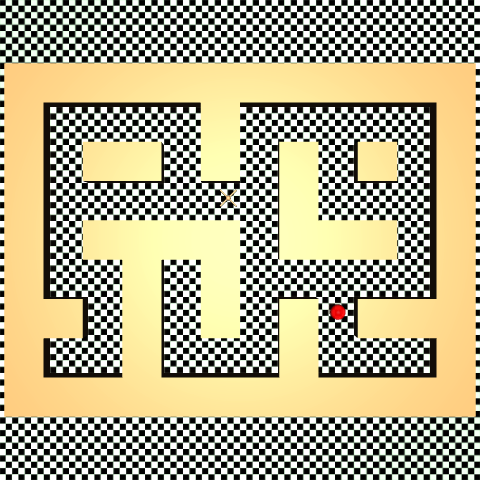

In [19]:
from PIL import Image

display(Image.fromarray(env.render()))